# Load Train and Test CSV

This method is only if you have obtained a cleaned version of the train and test dataset. 

The downside is that you wouldn't be able to highlight their start and end time. There is no flexibility.



In [1]:
# Upgrade Ram
i = []
while True:
  i.append(i)

KeyboardInterrupt: ignored

**G Drive Method**

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Train Data - df

**G Drive Method**

In [4]:
link_train = 'https://drive.google.com/file/d/1kYY_QI5Fc3umnMP5j5ICnD_nlZERgO62/view?usp=sharing' 

fluff, id = link_train.split('/d/')
id2, fluff2 = id.split('/view')
print (id2) # Verify 

fileDownloaded = drive.CreateFile({'id':f"{id2}"})

name = "BX"
fileDownloaded.GetContentFile(f"{name}.csv")

import pandas as pd
df = pd.read_csv(f"{name}.csv")

df.head()



1kYY_QI5Fc3umnMP5j5ICnD_nlZERgO62


,high,volume
0,23.628818,8941.0
1,23.597396,24572.0
2,23.597396,41230.0
3,23.589541,20162.0
4,23.581686,8427.0


**Local Upload Method**

In [5]:
# from google.colab import files
# uploaded = files.upload()


In [6]:
# import io
# df = pd.read_csv(io.BytesIO(uploaded['Filename.csv']))
# name = "BX"

# df.head()


In [7]:
print(f"No. of data points in {name} train dataset: {len(df)}")

No. of data points in BX train dataset: 387809


## Test Data - df2


**G Drive Method**

In [8]:
link_test = 'https://drive.google.com/file/d/1am2HmNbe1Dif6vFlTNfJEUAEjZEE3WFA/view?usp=sharing' 

fluff, id = link_test.split('/d/')
id2, fluff2 = id.split('/view')
print (id2) # Verify 

fileDownloaded = drive.CreateFile({'id':f"{id2}"})

name = "BX"
fileDownloaded.GetContentFile(f"{name}.csv")

import pandas as pd
df2 = pd.read_csv(f"{name}.csv")

df2.tail()


1am2HmNbe1Dif6vFlTNfJEUAEjZEE3WFA


,high,volume
21054,87.560,22015.0
21055,87.520,27653.0
21056,87.510,27347.0
21057,87.505,28316.0
21058,87.480,257990.0


**Local Upload Method**

In [9]:
# from google.colab import files
# uploaded = files.upload()


In [10]:
# import io
# df2 = pd.read_csv(io.BytesIO(uploaded['Filename.csv']))
# name = "BX"

# df2.head()


In [11]:
print(f"No. of data points in {name} test dataset: {len(df2)}")

No. of data points in BX test dataset: 21059


# List of Stocks

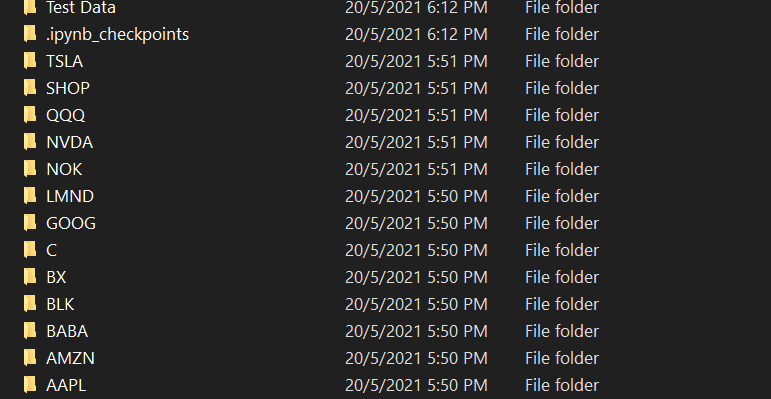

# Concat Train and Test Data 
**Easier for us to normalize**

In [12]:
frames = [df, df2]

ticker = pd.concat(frames)

ticker.head()

,high,volume
0,23.628818,8941.0
1,23.597396,24572.0
2,23.597396,41230.0
3,23.589541,20162.0
4,23.581686,8427.0


In [13]:
a = len(df) # Train Data Length
b = len(df2) # Test Data Length
c = a + b # Total Length

print(f"Length of Train Data: {a} \n Length of Test Data: {b} \n Length of Total Data: {c} ")

Length of Train Data: 387809 
 Length of Test Data: 21059 
 Length of Total Data: 408868 


# Creating Model

In [14]:
### IMPORT LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob



In [15]:
### SHARPE RATIO
def sharpe_ratio(rets): # mean returns over standard deviation of the returns
    return rets.mean() / rets.std()

In [16]:
### TRADER FUNCTION
# theta is our input parameters in this case the slope of our line
def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

In [17]:
### RETURNS
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [18]:
### GRADIENT ASCENT
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

In [19]:
### TRAIN MODEL
# ideal epoch size is around 210+ as it plateau off 
# using epoch = 300
def train(x, epochs=300, M=5, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

In [21]:
### LOAD DATA FROM ABOVE
rets = ticker['high'].diff()[1:]
x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) # normalize data


# Split Data

In [22]:


N = int(len(ticker)*(a/c)) # Train Length
P = int(len(ticker)*(b/c)) # Test Length
x_train = x[-(N+P):-P]
x_test = x[-P:]



# Execute Model

In [23]:
theta, sharpes = train(x_train, epochs=150, M=24, commission=0.0025, learning_rate=.01) # M is the look-back window

finished training


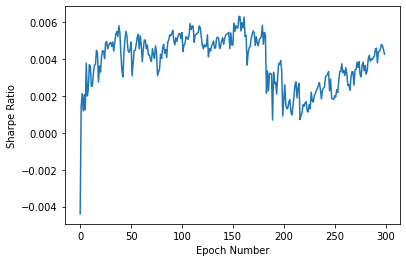

In [24]:
# Identify Optimal Epoch
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

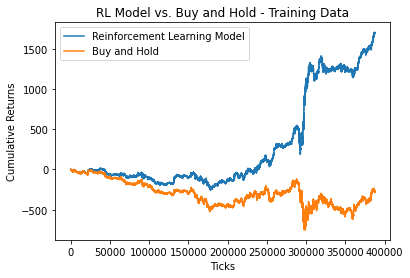

In [25]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_train.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

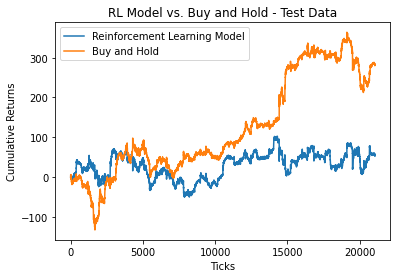

In [26]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");